# Selectivity categories for connectivity results

In [1]:
# return figures in svg
%config InlineBackend.figure_formats = ['png']

import h5py
import bayesprev
import numpy as np
import pandas as pd
from string import ascii_letters as abc

from itertools import product
from os.path import join as pjoin

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.font_manager as fm
import warnings
warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
analysis = 'connectivity'
minimal = 10
alpha = .01
cat_df = {}
b_d = {}
d = {}

In [3]:
sounds = ['speech', 'music']
hemis = ['left', 'right']
orientations = ['left', 'right', 'top', 'front']

# all bands
bands = ['delta', 'theta', 'alpha', 'beta', 'lga', 'hfa']
bands_r = ((1, 4), (5, 8), (8, 12), (18, 30), (30, 50), (80, 120))

In [4]:
color = {
    'speech': [  # red
        np.array((242, 152, 154)).reshape(1, -1),
        np.array((254, 75, 73)).reshape(1, -1),
    ],
    'music': [  # blue
        np.array((148, 210, 221)).reshape(1, -1),
        np.array((43, 183, 200)).reshape(1, -1),
    ],
    'shared': [  # yellow tones
        np.array((255, 255, 255)).reshape(1, -1),
        np.array((255, 255, 255)).reshape(1, -1),
    ]}

In [5]:
regions = {'Left': {'Frontal': ['IFG, Left Inf', 'MFG, Left Mid', 'OrG, Left Orb', 'PCL, Left Par', 'PrG, Left Pre', 'SFG, Left Sup'],
                    'Temporal': ['FuG, Left Fus', 'ITG, Left Inf', 'MTG, Left Mid', 'PhG, Left Par', 'STG, Left Sup', 'pSTS, Left po'],
                    'Parietal': ['IPL, Left Inf', 'Pcun, Left Pr', 'PoG, Left Pos', 'SPL, Left Sup'], 'Insular': ['INS, Left Ins'],
                    'Subcortical': ['Amyg, Left Am', 'BG, Left Basa', 'Hipp, Left Hi', 'Tha, Left Tha']},
           'Right': {'Frontal': ['IFG, Right In', 'MFG, Right Mi', 'OrG, Right Or', 'PrG, Right Pr', 'SFG, Right Su'],
                     'Temporal': ['FuG, Right Fu', 'ITG, Right In', 'MTG, Right Mi', 'PhG, Right Pa', 'STG, Right Su', 'pSTS, Right p'],
                     'Parietal': ['IPL, Right In', 'Pcun, Right P', 'PoG, Right Po', 'SPL, Right Su'],
                     'Insular': ['INS, Right In'], 'Limbic': ['CG, Right Cin'],
                     'Subcortical': ['Amyg, Right A', 'BG, Right Bas', 'Hipp, Right H', 'Tha, Right Th']}
           }
lobes = ['Frontal', 'Insular', 'Temporal', 'Subcortical', 'Parietal'][::-1]

In [6]:
# some helper functions

def jn(mlist, char=None):
    if not char:
        char = '_'
    string = char.join(mlist)
    return string


def flatten(nested):
    flatl = [item for sublist in nested for item in sublist]
    empty_l = [np.asarray(flatl).shape[i]
               for i in range(np.asarray(flatl).ndim)]
    tup = tuple(empty_l)
    flat_list = np.array(flatl).reshape(tup)
    return flat_list


def split_hemis(chlist):
    left_names, right_names = [], []
    left_index, right_index = [], []
    for i, ch in enumerate(chlist):
        if "'" in ch:
            left_names.append(ch)
            left_index.append(i)
        else:
            right_names.append(ch)
            right_index.append(i)
    return (left_names, right_names, left_index, right_index)


def get_name(data, analysis=analysis, condition=None):
    if condition:
        cname = jn([analysis, 'left_fourier', condition, data, 'sign'])
    else:
        cname = jn([analysis, 'difference', data, 'sign'])
    return cname

## Prepare DataFrame

### **Collect base data** from presaved DF and add **main effects** for **delta & hfa**

In [7]:
with pd.HDFStore(pjoin('data', 'ispeech_connectivity.h5'), mode='r') as store:
    df = store.select('df')
chns = df['chnames'].values
sujs = np.unique(df.subject)
sujs

array(['sub-14c725b6b803', 'sub-26176ef8a8d0', 'sub-28e70e7c7fbb',
       'sub-3ef8645f99c5', 'sub-4247d6d6cdbf', 'sub-44375d501493',
       'sub-83ebd5328120', 'sub-95a634be7e05', 'sub-9d783b836f5e',
       'sub-c1b7ce54ce05', 'sub-c2a96116ddc4', 'sub-cacae171ee15',
       'sub-e0bb6ccef2a5', 'sub-ebf231d97f73', 'sub-fccb4adbfadc'],
      dtype=object)

---
---
### Prepare intersections

***shared***:
- main effect for both significant and no difference effect (green) -> both_no
    
***almost shared***:
- main effect for speech but no difference effect -> sp_no
- main effect for music but no difference effect -> mu_no
    
***preferred***:
- main effect for both but difference effect for speech -> both_sp 
- main effect for both but difference effect for music -> both_mu 

***selective***:
- main effect only for speech plus difference effect (red) -> sp_sp
- main effect only for music plus difference (effect (blue) -> mu_mu
    
***impossible situation but check for it***:
- neither but difference speech -> no_sp
- neither but difference music -> no_mu
---

***shared***

In [8]:
include_almost_shared = True
for band in bands:
    temp = df
    columns = [get_name(data=band, condition=sound) for sound in sounds]

    print(band, len(temp.loc[(temp[columns].notnull().any(axis=1))]))

    # including almost shared
    if include_almost_shared:
        cat_df['shared_' + band] = temp.loc[(temp[columns].notnull().any(
            axis=1)) & ~(temp[get_name(data=band)].notnull())]

    # excluding almost shared
    else:
        cat_df['shared_' + band] = temp.loc[(temp[columns].notnull().all(
            axis=1)) & ~(temp[get_name(data=band)].notnull())]

    print(band, '-> shared %s' % len(cat_df['shared_' + band]))

delta 532
delta -> shared 330
theta 662
theta -> shared 457
alpha 593
alpha -> shared 429
beta 194
beta -> shared 143
lga 136
lga -> shared 111
hfa 190
hfa -> shared 133


***preferred***

In [9]:
for band in bands:
    temp = df
    columns = [get_name(data=band, condition=sound) for sound in sounds]
    cat_df['speech_preferred_' + band] = temp.loc[(
        temp[columns].notnull().all(axis=1)) & (temp[get_name(data=band)] > 0)]
    cat_df['music_preferred_' + band] = temp.loc[(
        temp[columns].notnull().all(axis=1)) & (temp[get_name(data=band)] < 0)]
    print(band, '->',
          'speech: %s;' % len(cat_df['speech_preferred_' + band]),
          'music: %s;' % len(cat_df['music_preferred_' + band]))

delta -> speech: 38; music: 69;
theta -> speech: 57; music: 66;
alpha -> speech: 41; music: 50;
beta -> speech: 22; music: 8;
lga -> speech: 8; music: 6;
hfa -> speech: 16; music: 13;


***selective***

In [10]:
for band in bands:
    temp = df
    cat_df['speech_selective_' + band] = temp.loc[(temp[get_name(data=band, condition='speech')] > 0) & ~(
        temp[get_name(data=band, condition='music')] > 0) & (temp[get_name(data=band)] > 0)]
    cat_df['music_selective_' + band] = temp.loc[~(temp[get_name(data=band, condition='speech')] > 0) & (
        temp[get_name(data=band, condition='music')] > 0) & (temp[get_name(data=band)] < 0)]
    print(band, '->',
          'speech: %s;' % len(cat_df['speech_selective_' + band]),
          'music: %s;' % len(cat_df['music_selective_' + band]))

delta -> speech: 42; music: 53;
theta -> speech: 26; music: 56;
alpha -> speech: 23; music: 50;
beta -> speech: 12; music: 9;
lga -> speech: 3; music: 8;
hfa -> speech: 7; music: 21;


## Grid: **Electrodes distribution** (MNI) and **overview categories** (nested pies) per band

Some **plotting prefixes**

In [12]:
# fontsizes
fticks = 27
flabels = 35
fcount = 52
lwidth = 2  # line width
size = .3  # pie sizes

# filters to loop over
visuals = ['shared', 'preferred', 'selective']
bars = ['shared', 'speech_preferred', 'music_preferred',
        'speech_selective', 'music_selective']

emdash = u'\u2014'
hatchp = 'x'

outer_colors = [np.array((255, 255, 255)).reshape(1, -1) / 255,
                np.array((52, 52, 53)).reshape(1, -1) / 255,
                'grey']
inner_colors = [color['shared'][1] / 255] + [color[sound]
                                             [1] / 255 for i, sound in product(range(2)[::-1], sounds)]

brains = hemis

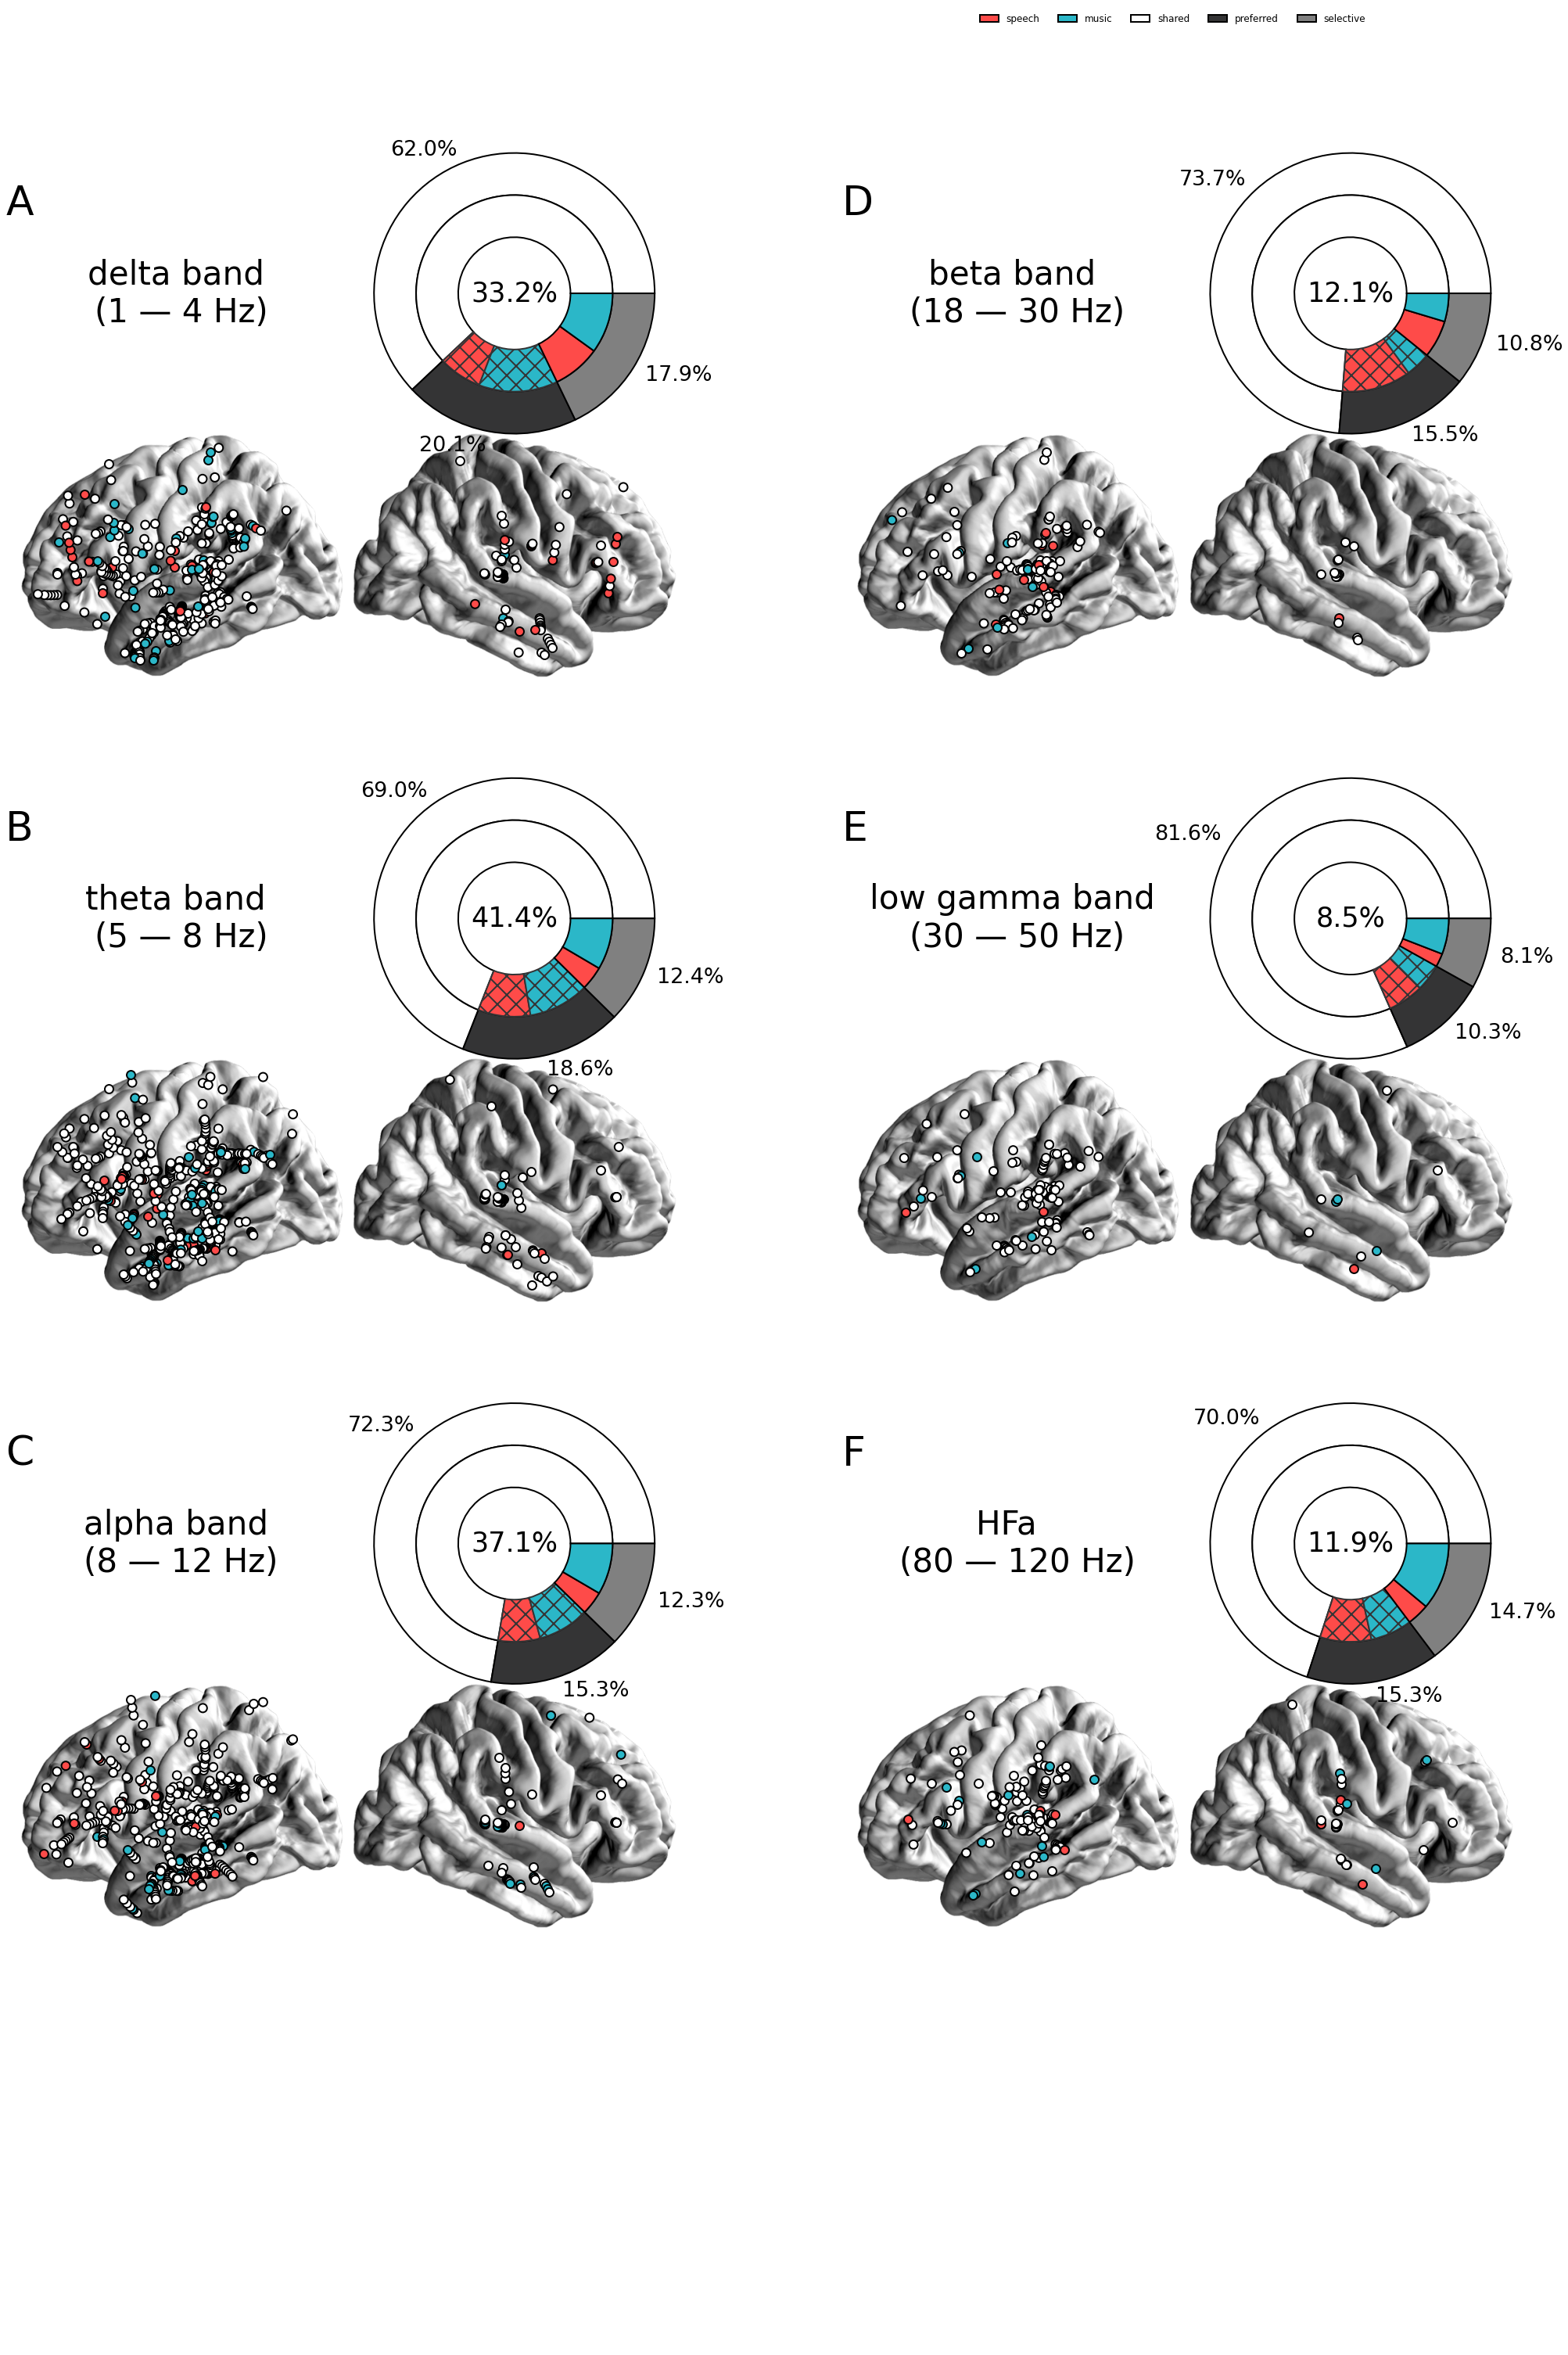

In [13]:
fig3 = plt.figure(figsize=(27, 37), constrained_layout=False)

for z, band in enumerate(bands[:]):
    gs = fig3.add_gridspec(2, 2,
                           wspace=-.05,
                           hspace=-.3,
                           left=0 if z < 3 else .55,
                           right=.45 if z < 3 else 1,
                           bottom=(3 - z % 3) * .3,
                           top=((3 - z % 3) + 1) * .3)

    band_name = 'HFa' if band == 'hfa' else 'low gamma' if band == 'lga' else band

    # Brain figure
    ##############################################################################
    for o, orientation in enumerate(brains):

        # which axes
        con_orientation = fig3.add_subplot(gs[1, o])
        axes = con_orientation

        # collect stored mayavi brain images
        with h5py.File(pjoin('data', 'bg_img.hdf5'), 'r') as hf:
            im = hf[orientation][...]
        axes.imshow(im)

        for j in range(20):
            for v, viz in enumerate(visuals):
                if viz == 'preferred':
                    continue
                for sound in sounds:
                    if viz != 'shared':
                        label = jn([sound, viz, band])
                    else:
                        if sound == 'music':
                            continue
                        label = jn([viz, band])
                    # filter dataframe and move on if nothing matches
                    t_df = cat_df[label]
                    t_df = t_df.loc[(t_df['chorder'] == str(j))]
                    if len(t_df) == 0:
                        continue

                    # connecting seed to subject
                    for subject in sujs:
                        temp_df = t_df.loc[(t_df['subject'] == subject)]

                        # collect coordinates
                        df_x = temp_df[jn([orientation, 'x'])].values
                        df_y = temp_df[jn([orientation, 'y'])].values
                        left_i, right_i = [], []
                        for i, ch in enumerate(temp_df['chnames'].values):
                            if "'" in ch:
                                left_i.append(i)
                            else:
                                right_i.append(i)
                        if orientation in hemis:
                            x_h = df_x[left_i] if orientation == 'left' else df_x[right_i]
                            y_h = df_y[left_i] if orientation == 'left' else df_y[right_i]
                        else:
                            x_h = df_x
                            y_h = df_y

                        # plot elecs scatterplot
                        axes.scatter(x_h,
                                     y_h,
                                     zorder=3,
                                     edgecolors='k',
                                     color=outer_colors[v] if 'selective' not in viz else color[label.split('_')[
                                         0]][1] / 255,
                                     label='%s %s' % (len(x_h), label),
                                     s=120 * np.ones(len(x_h)))

                        # clean up subplot
                        axes.set_axis_off()

    # Bad title figure
    ##############################################################################
    band_title = fig3.add_subplot(gs[0, 0])
    axes = band_title
    axes.set_title(abc[z].upper(), fontsize=fcount, loc='left', y=0.7)
    axes.text(.5,
              .5,
              '%s %s \n(%s %s %s Hz)' % (
                  band_name,
                  'band' if band != 'hfa' else '',
                  bands_r[z][0],
                  emdash,
                  bands_r[z][1]),
              fontsize=fcount-10,
              ha='center', va='center')
    # clean up subplot
    axes.set_axis_off()

    # Nested pie figure
    ##############################################################################
    nested_pie = fig3.add_subplot(gs[0, 1])
    # Turn off axes and set axes limits
    axes = nested_pie

    # prepare counts per category for the rings
    inner_len = [len(cat_df[jn([bar, band])]) for bar in bars]
    outer_len = [len(cat_df[jn(['shared', band])])] + [len(cat_df[jn(['speech', viz, band])]
                                                           ) + len(cat_df[jn(['music', viz, band])]) for viz in visuals[1:]]

    # sum of significant electrodes
    all_sum = np.array([len(cat_df[jn([bar, band])]) for bar in bars]).sum()

    # percentage significant electrodes over whole brain
    # in total and per category
    p_overbrain = np.round((all_sum / len(df)) * 100, 1)
    percentages = ['%s%%' % np.round((j / all_sum) * 100, 1)
                   for j in outer_len]

    # plot outer pie
    axes.pie(outer_len,
             radius=1,
             colors=outer_colors,
             labels=percentages,
             textprops={'fontsize': fticks},
             wedgeprops=dict(width=size, edgecolor='k', linewidth=lwidth))

    # inner pie
    inner = axes.pie(inner_len,
                     radius=1 - size,
                     colors=inner_colors,
                     wedgeprops=dict(width=size, edgecolor='k', linewidth=lwidth))

    # add hatch pattern to preferred
    for h in range(2):
        inner[0][h+1].set_hatch(hatchp)
        inner[0][h+1].set_edgecolor(np.array((52, 52, 53)
                                             ).reshape(1, -1) / 255)

    axes.text(0., 0.,
              '%s%%' % (p_overbrain),
              fontsize=flabels,
              ha='center',
              va='center')


# prepare legend
###########################################################################################
gs = fig3.add_gridspec(1, 2, top=1.25)
legend_s = fig3.add_subplot(gs[0, :])
axes = legend_s

# legend patches
sounds_l = [mpatches.Patch(facecolor=color[sound][1] /
                           255, label=sound, edgecolor='k', linewidth=lwidth) for sound in sounds]
category_l = [mpatches.Patch(facecolor=outer_colors[i], edgecolor='k', label=cat)
              for i, cat in enumerate(visuals)]
axes.legend(handles=sounds_l + category_l,
            ncol=6,
            loc='upper right',
            labelspacing=.7)
axes.set_axis_off()

## Prevalence

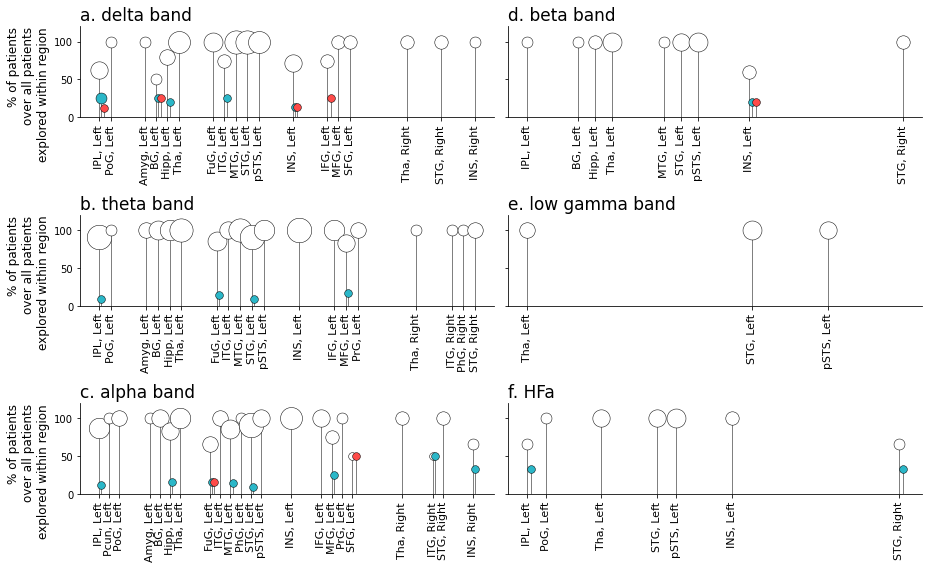

In [14]:
selects = ('speech', 'music', 'shared', )[::-1]
minimum = 1

fig, ax = plt.subplots(3, 2, figsize=(13, 8), sharey=True)
legend_u = []
for b, band in enumerate(bands):
    # print(int(b/3), b%3)
    axes = ax[b % 3, int(b/3)]
    columns = ['connectivity_left_fourier_%s_%s_sign' %
               (sound, band) for sound in sounds]
    s_df = df.loc[(df[columns].notnull().any(axis=1))]
    counter = 0
    ylabels = []
    yticks = []
    for hem, lobe in product(('Left', 'Right', ), lobes):
        counter += 1
        for j, r in enumerate(regions[hem][lobe]):
            total_s = 0
            for select in selects:
                b_d[select] = 0
            temp = s_df.loc[(s_df['brainnetome']).str.startswith(r)]
            nrsujs = len(set(temp['subject']))
            nrelecs = len(df.loc[(df['brainnetome']).str.startswith(r)])
            for subject in set(temp['subject']):
                t = temp.loc[(temp['subject'] == subject)]
                if len(t) > minimum:
                    if not all([len(
                            t['connectivity_left_fourier_%s_%s_sign' % (sound, band)].dropna()) for sound in sounds]):
                        if len(t['connectivity_difference_%s_sign' % band].dropna()):
                            if len(t['connectivity_left_fourier_%s_%s_sign' % ('speech', band)].dropna()):
                                total_s += 1
                                b_d['speech'] += 1
                            else:
                                total_s += 1
                                b_d['music'] += 1
                    else:
                        if len(t.loc[~(t['connectivity_difference_%s_sign' % band] > 0)]):
                            total_s += 1
                            b_d['shared'] += 1
            if total_s > minimum:
                counter += .5
                for c, k in enumerate(selects):
                    xmap = bayesprev.map(b_d[k], total_s, alpha)
                    if xmap == 0:
                        continue
                    label = jn(r.split(' ')[:2], ' ')
                    if label not in ylabels:
                        ylabels.append(jn(r.split(' ')[:2], ' '))
                        yticks.append(counter)
                    perc = (b_d[k]/total_s) * 100
                    axes.plot([counter + (c/10), counter + (c/10)],
                              [0, perc],
                              linewidth=1,
                              zorder=1,
                              color='grey')
                    axes.scatter(counter + (c/10),
                                 perc,
                                 s=b_d[k]*60,
                                 facecolor=np.append((color[k][1] / 255), 1),
                                 linewidth=.5,
                                 edgecolor='k',
                                 label=b_d[k],
                                 zorder=2,
                                 alpha=1)

    if band == 'hfa':
        band = 'HFa'
    elif band == 'lga':
        band = 'low gamma'
        # fake legend
        lgd = axes.scatter(np.ones(15) * 5,
                           range(15),
                           alpha=0,
                           s=range(15),
                           facecolor='w',
                           edgecolor='k',
                           label=[str(i) for i in range(15)],
                           clip_on=False)
        handles, labels = lgd.legend_elements(
            prop="sizes", color='grey', linewidth=1, alpha=1)

    # axes.legend()
    axes.set_title('%s. %s %s' % (
        abc[b], band, 'band' if band != 'HFa' else ''), fontsize=17)
    axes.set_xticks(yticks)
    axes.set_xticklabels(ylabels, rotation=90, fontsize=11)
    axes.xaxis.grid(False)
    axes.yaxis.grid(False)
    axes.set_ylim([0, 120])
    if b < 3:
        axes.set_ylabel(
            '% of patients\nover all patients\nexplored within region')

fig.tight_layout()